In [1]:
# %% Import required libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Define training parameters
training_start_date = '1970-02-02'
training_end_date = '2024-06-01'
prediction_start_date = '2024-06-02'
prediction_end_date = '2024-10-25'
batch_size = 16
hidden_size = 64
output_size = 1

In [3]:
# %% Load and preprocess data
df_full = pd.read_csv('yahoo_finance.csv')
df_full['Date'] = pd.to_datetime(df_full['Date'])
df_full.set_index('Date', inplace=True)

In [4]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size // 2, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size // 2, output_size)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x[:, -1, :])  # Use only the last output
        x = self.fc(x)
        return x

In [5]:
# Prepare the training data
def prepare_data(df, n_past, smoothing_window=5, n_future=1):
    cols = list(df)[1:6]  # Adjust based on your DataFrame structure
    df_for_training = df[(df.index >= training_start_date) & (df.index <= training_end_date)][cols].astype(float)

    # Apply smoothing to each column
    df_smoothed = df_for_training.rolling(window=smoothing_window, min_periods=1).mean()

    # Normalize smoothed training data
    scaler = StandardScaler()
    df_for_training_scaled = scaler.fit_transform(df_smoothed)

    # Prepare data for LSTM
    trainX, trainY = [], []
    for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
        trainX.append(df_for_training_scaled[i - n_past:i, :])
        trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])  # Predicting the first column

    trainX, trainY = np.array(trainX), np.array(trainY)
    return trainX, trainY, scaler, df_smoothed, cols


In [6]:
# Define function to train model with a given window size and num_epochs
def train_model(n_past, num_epochs=5, batch_size=32):
    trainX, trainY, scaler, df_for_training, cols = prepare_data(df_full, n_past)

    # Convert numpy arrays to torch tensors
    trainX = torch.from_numpy(trainX).float()
    trainY = torch.from_numpy(trainY).float().view(-1, 1)

    # Split the data into training and validation sets
    train_size = int(len(trainX) * 0.8)
    trainX_tensor, valX_tensor = trainX[:train_size], trainX[train_size:]
    trainY_tensor, valY_tensor = trainY[:train_size], trainY[train_size:]

    # Create data loaders for training and validation
    train_dataset = torch.utils.data.TensorDataset(trainX_tensor, trainY_tensor)
    val_dataset = torch.utils.data.TensorDataset(valX_tensor, valY_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize model, criterion, and optimizer
    model = LSTMModel(input_size=trainX.shape[2], hidden_size=hidden_size, output_size=output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Track losses for plotting
    train_losses = []
    val_losses = []

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        # Calculate average training loss for this epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(valX_tensor)
            val_loss = criterion(val_outputs, valY_tensor).item()
            val_losses.append(val_loss)

    # Calculate final validation metrics
    val_outputs = val_outputs.numpy()
    valY_tensor = valY_tensor.numpy()
    mse = mean_squared_error(valY_tensor, val_outputs)
    mae = mean_absolute_error(valY_tensor, val_outputs)
    r2 = r2_score(valY_tensor, val_outputs)

    return mse, mae, r2, train_losses, val_losses

In [8]:
# Test different window sizes and epoch values
window_sizes = [5, 10, 20, 60, 100]  # Example window sizes
epoch_values = [5, 10, 20, 30]      # Example values for num_epochs
results = []

In [ ]:
# Run the training loop
for window_size in window_sizes:
    for epochs in epoch_values:
        print(f"Testing with window_size={window_size} and num_epochs={epochs}")
        
        # Train the model with the specified window size and epoch count

In [ ]:
        mse, mae, r2, train_losses, val_losses = train_model(n_past=window_size, num_epochs=epochs, batch_size=batch_size)
        
        # Append results to the list
        results.append({
            'Window Size': window_size,
            'Epochs': epochs,
            'MSE': mse,
            'MAE': mae,
            'R²': r2
        })

        # Plot training and validation losses
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label="Training Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss (MSE)")
        plt.title(f"Training and Validation Loss over Epochs\n(Window Size: {window_size}, Epochs: {epochs})")
        plt.legend()
        plt.show()

# Create a DataFrame to summarize results
results_df = pd.DataFrame(results)
print(results_df)

Testing with window_size=5 and num_epochs=5


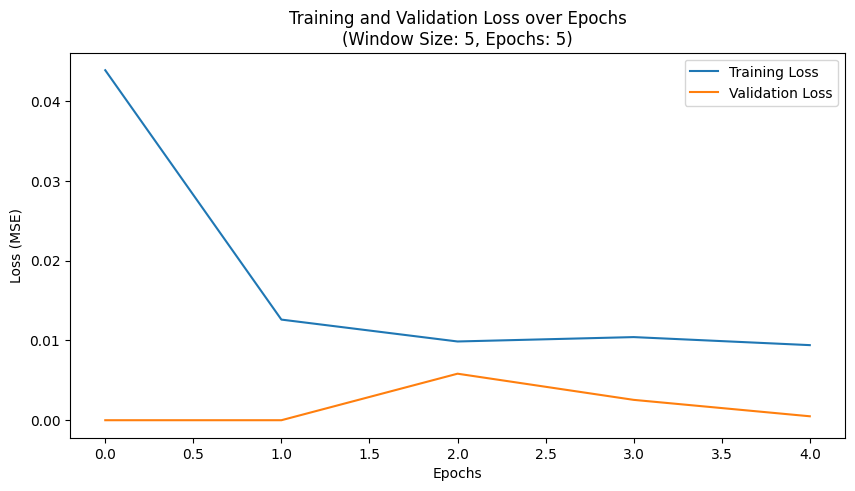

Testing with window_size=5 and num_epochs=10


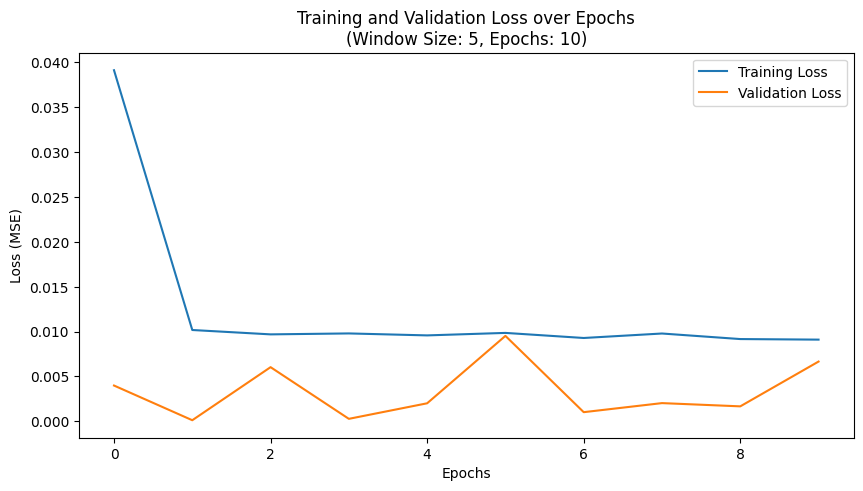

Testing with window_size=5 and num_epochs=20


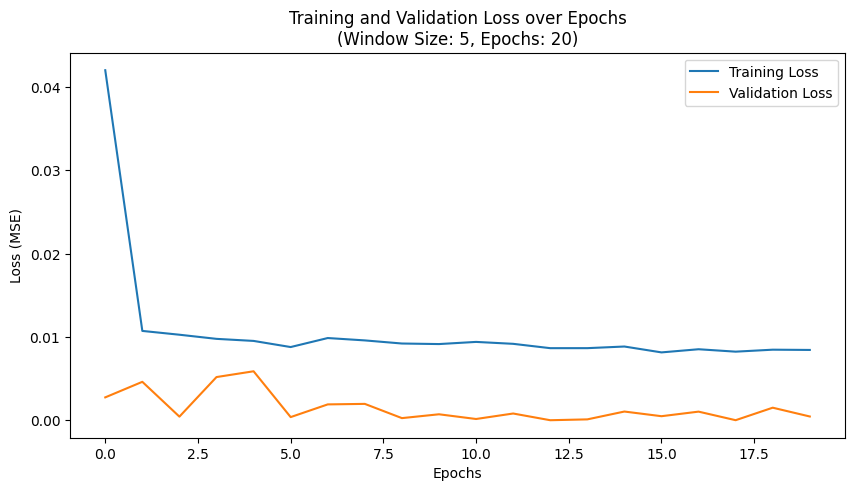

Testing with window_size=5 and num_epochs=30


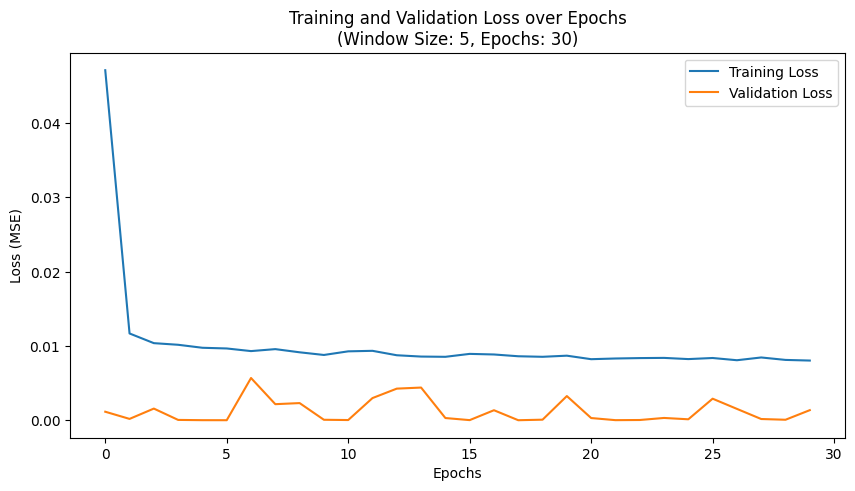

Testing with window_size=10 and num_epochs=5


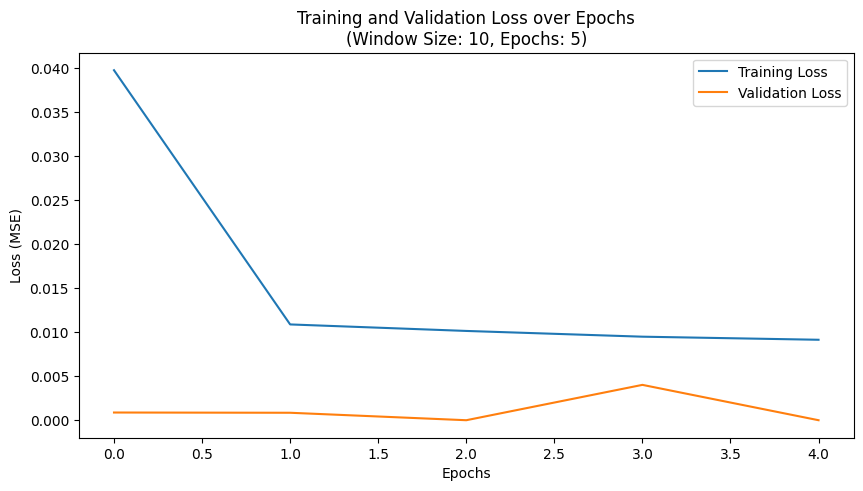

Testing with window_size=10 and num_epochs=10


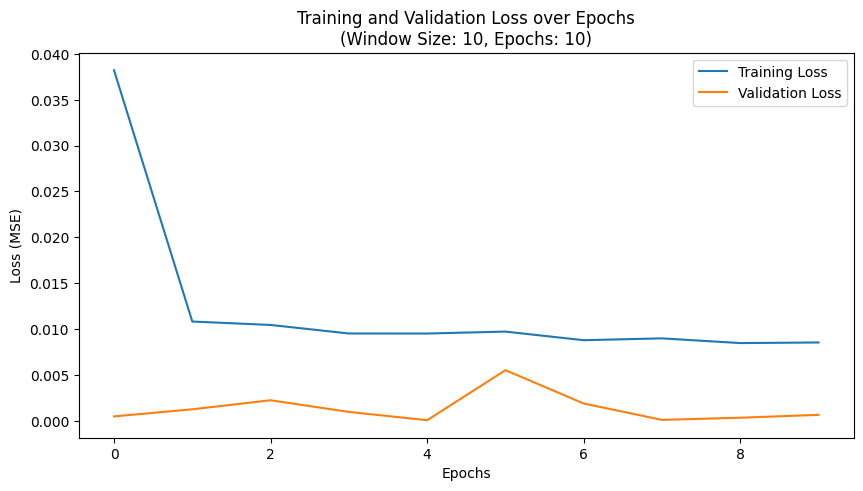

Testing with window_size=10 and num_epochs=20


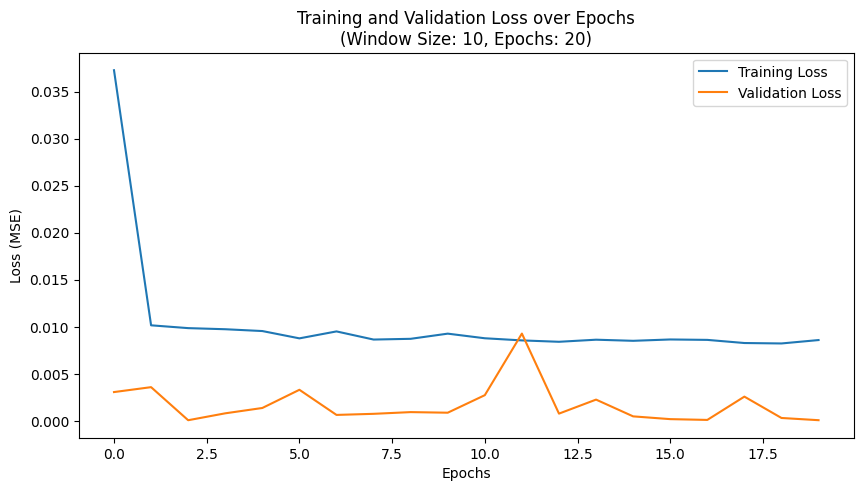

Testing with window_size=10 and num_epochs=30


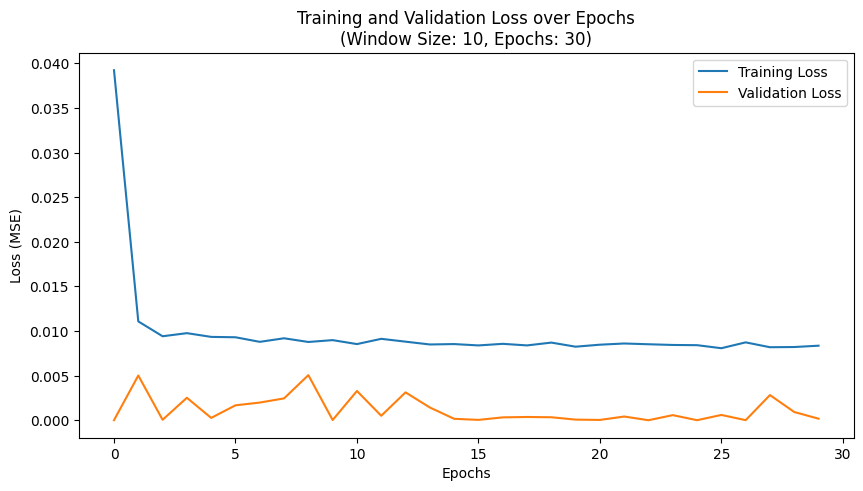

Testing with window_size=20 and num_epochs=5


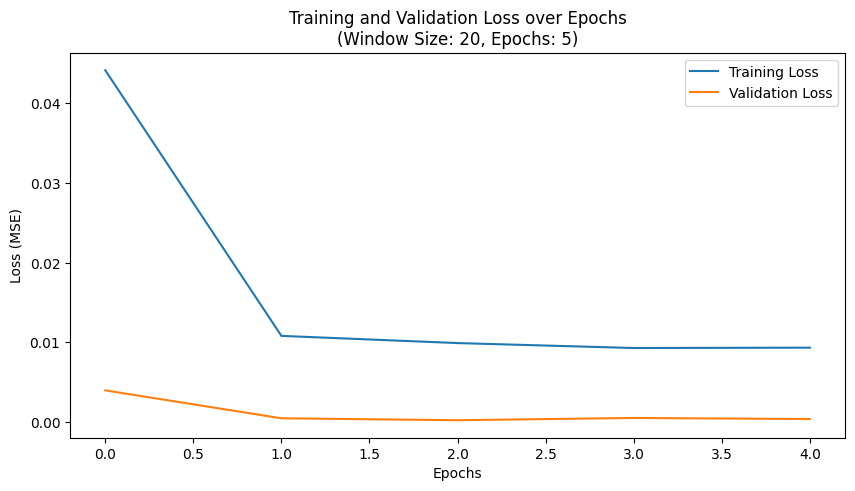

Testing with window_size=20 and num_epochs=10


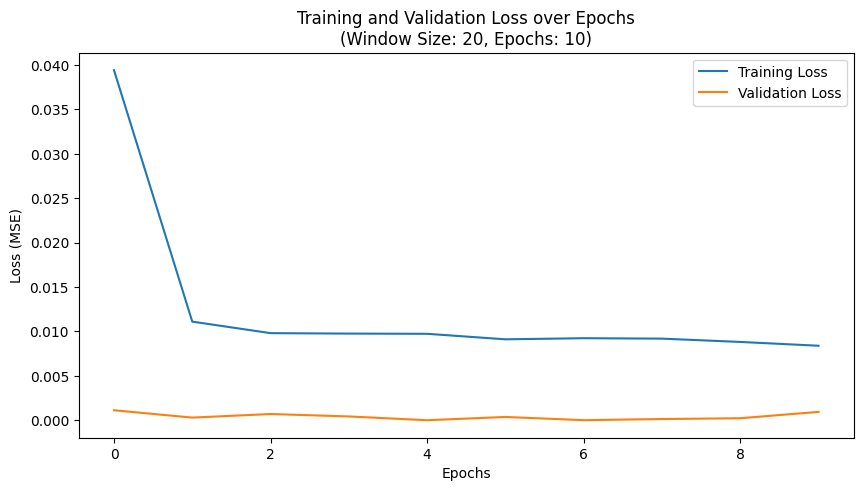

Testing with window_size=20 and num_epochs=20


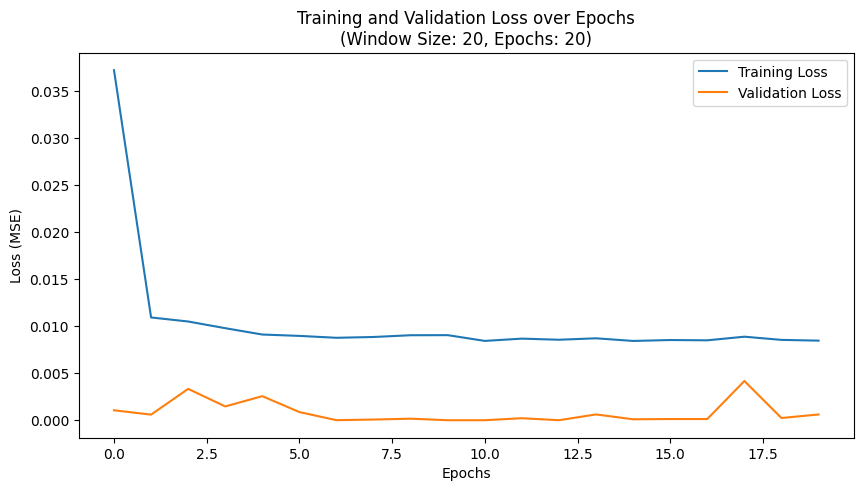

Testing with window_size=20 and num_epochs=30


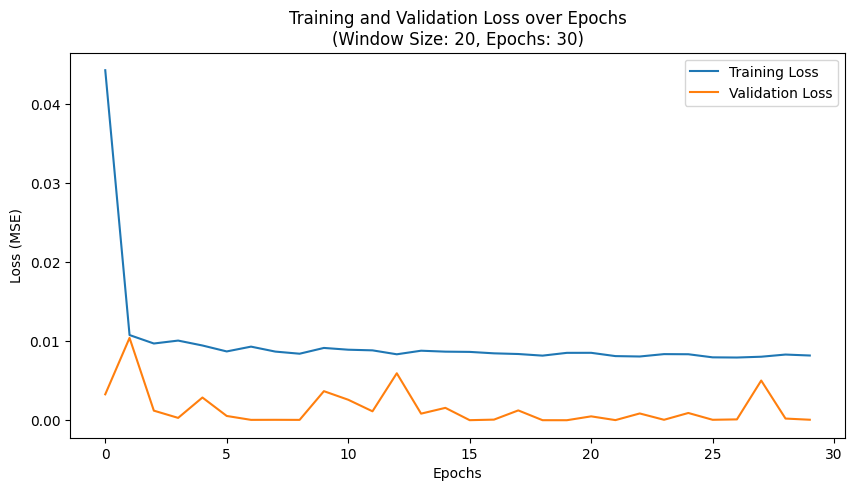

Testing with window_size=60 and num_epochs=5


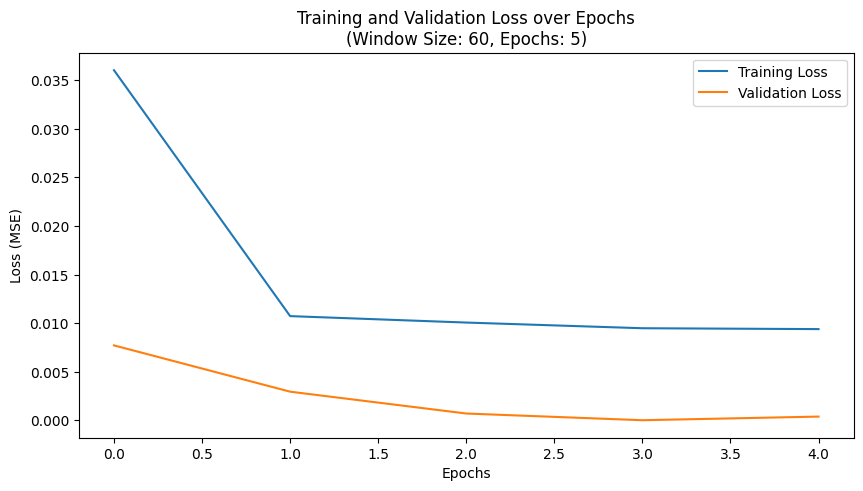

Testing with window_size=60 and num_epochs=10


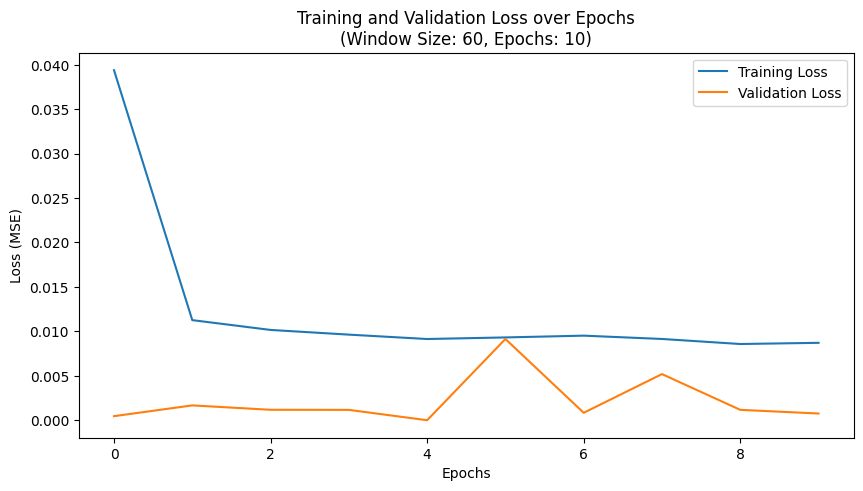

Testing with window_size=60 and num_epochs=20


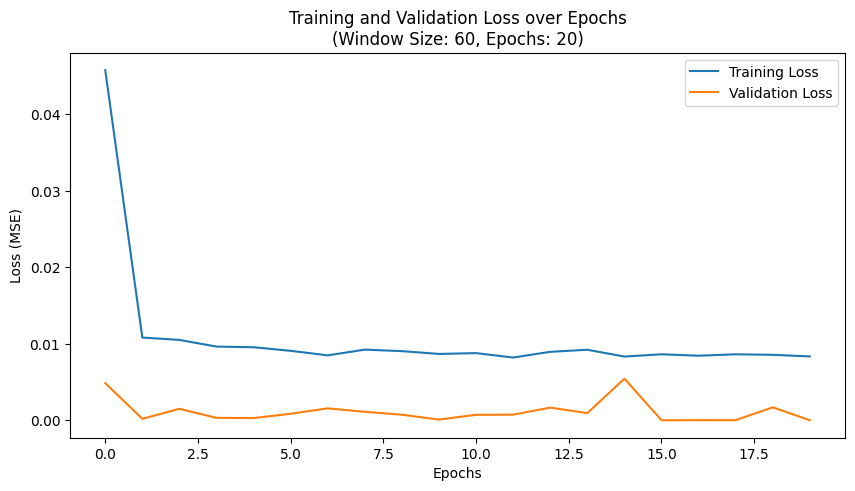

Testing with window_size=60 and num_epochs=30


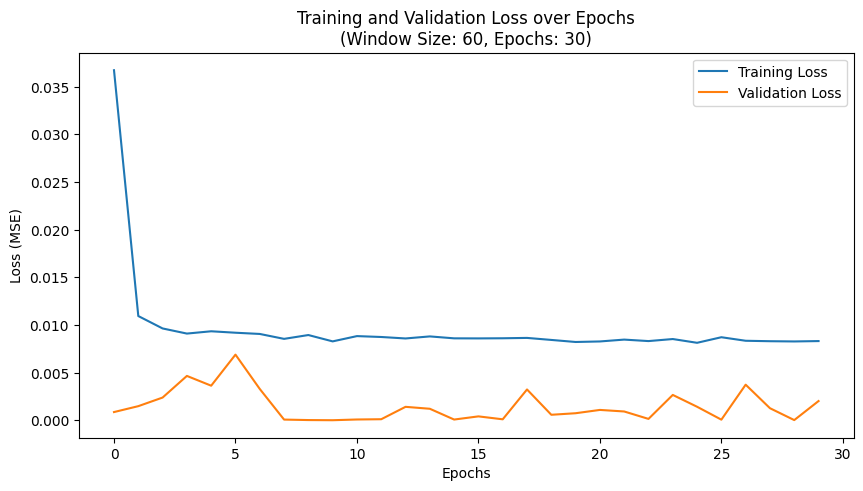

Testing with window_size=100 and num_epochs=5


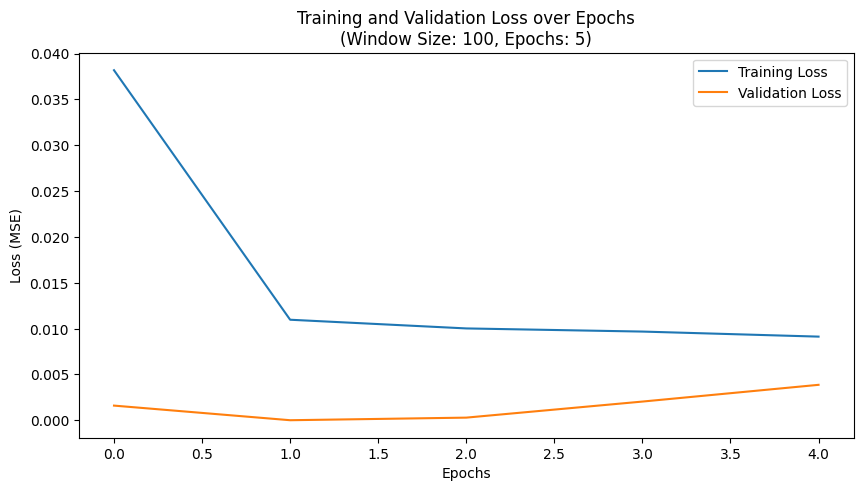

Testing with window_size=100 and num_epochs=10


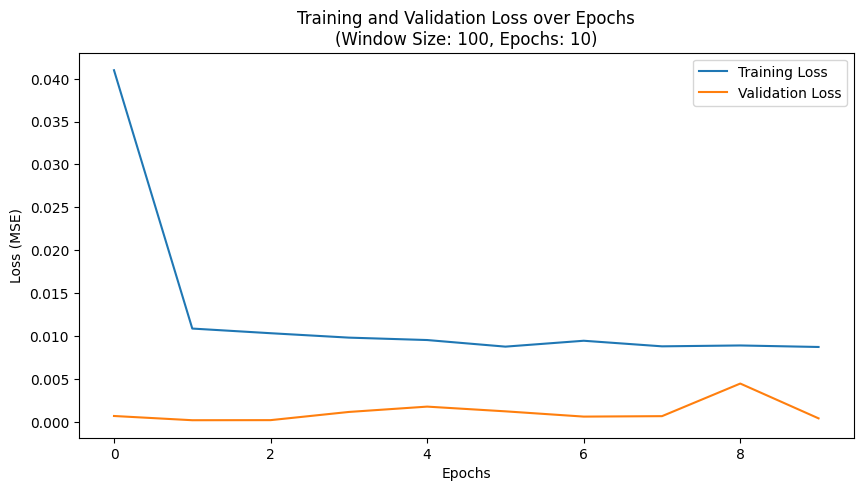

Testing with window_size=100 and num_epochs=20


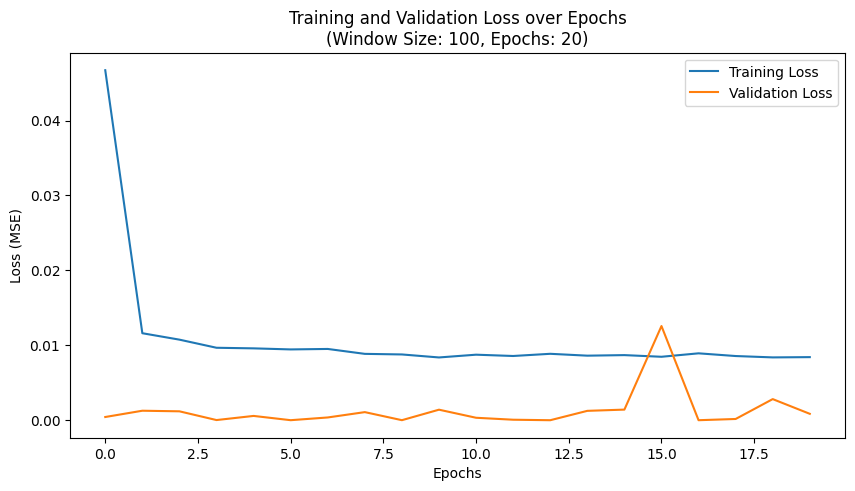

Testing with window_size=100 and num_epochs=30


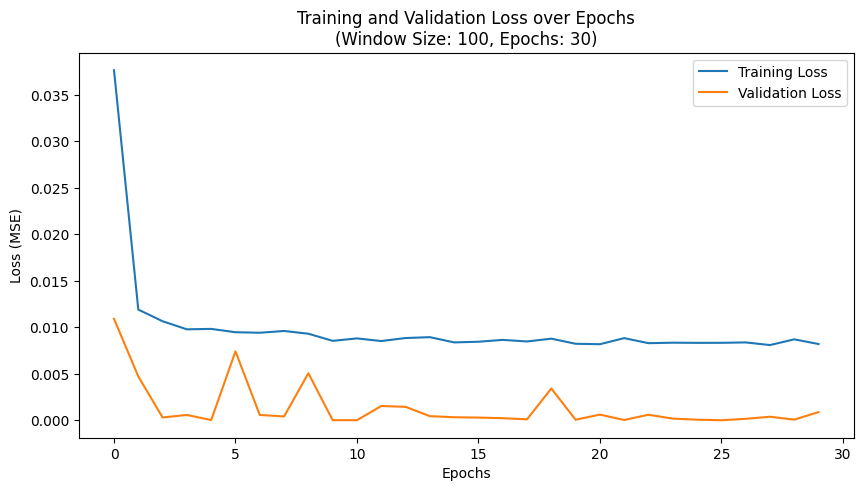

    Window Size  Epochs       MSE       MAE         R²
0             5       5  0.000006  0.001960   0.963451
1             5      10  0.000310  0.017347  -0.822023
2             5      20  0.000005  0.001686   0.971817
3             5      30  0.000035  0.005546   0.792560
4            10       5  0.000244  0.015418  -0.430336
5            10      10  0.002117  0.045946 -11.433819
6             5       5  0.000505  0.022397  -1.963016
7             5      10  0.006649  0.081494 -38.049755
8             5      20  0.000456  0.021244  -1.675559
9             5      30  0.001362  0.036856  -7.000354
10           10       5  0.000012  0.002927   0.926894
11           10      10  0.000652  0.025487  -2.831118
12           10      20  0.000047  0.006714   0.723459
13           10      30  0.000176  0.013199  -0.035200
14           20       5  0.000402  0.019915  -1.362458
15           20      10  0.000946  0.030688  -4.552783
16           20      20  0.000618  0.024832  -2.629005
17        